# Datenauswertung

#### Importiere Bibliotheken

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [7]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit
from pre_processing_plain import *
from pre_processing_partial_unload import *
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
hide_toggle()

## Plotten von simulierten Daten und Fitting

Fitting Funktion: $ P = \alpha*(h-hf)^m $

In [3]:
m_slider = widgets.FloatSlider(min=1,max=2, step=0.1)
a_slider = widgets.FloatSlider(value=0.1, min=0.05,max=1, step=0.05)
noise_P_slider = widgets.FloatSlider(value=0.1, min=0,max=10, step=0.05)
fit_range_slider = widgets.FloatRangeSlider(value=[0.3, 0.95], min=0, max=1, step=0.05)
n_points_slider = widgets.IntSlider(value=100, min=0,max=1000, step=10)
h_f_slider = widgets.IntSlider(value=0, min=0,max=100, step=5)
h_max = 100 #[nm]
#h_f = 0
#noise_std_h = 0.1
#noise_h = np.random.normal(0,noise_std_h, n_points)


def plotfit(m=1.3, alpha=0.1, noise_std_P=0.5, fit_range=[0.3,0.95], n_points=100, h_f=0):
    h = np.linspace(0, h_max, n_points)#[nm]
    noise_P = np.random.normal(0,noise_std_P,n_points)
    P = alpha*(h - h_f)**m+noise_P     #[nN]
    plt.plot(h , P, label='simulated data')
    plt.xlabel('depth [nm]')
    plt.ylabel('Force [nN]')
    popt_log, pcov_log = fitting(h, np.log(P), fit_range, (0.1, 2, 0), fit_func=func_log) 
    popt_exp, pcov_exp = fitting(h, P, fit_range, (0.1,1,0), fit_func=func_exp)
    plt.plot(h, func_exp(h, *popt_log), label = 'log fit')
    plt.plot(h, func_exp(h, *popt_exp), label = 'power law fit')
    plt.legend()
             
    print('Kurvenparameter (alpha, m, hf:)',popt_log)
    print('Abweichung von Modellparametern (log fit):')
    print('\ndelta alpha=', 100*((alpha-popt_log[0])/alpha),'%')
    print('delta m =', 100*((m-popt_log[1])/m),'%')
    print('delta hf =', h_f-popt_log[2],'[nm]')
    print('\nAbweichung von Modellparametern (power law fit):')
    print('\ndelta alpha=', 100*((alpha-popt_exp[0])/alpha),'%')
    print('delta m =', 100*((m-popt_exp[1])/m),'%')
    print('delta hf =', h_f-popt_exp[2],'[nm]')

widgets.interact(plotfit, m=m_slider, alpha=a_slider, noise_std_P=noise_P_slider, fit_range=fit_range_slider,
                 n_points=n_points_slider, h_f=h_f_slider)

hide_toggle()

interactive(children=(FloatSlider(value=1.0, description='m', max=2.0, min=1.0), FloatSlider(value=0.1, descri…

### Analyse des Fitting Algorithmus

Genutzt wurde die Python Funktion 'curve_fit' aus der scipy Bibliothek. Es wurde die oben dargestellte Fitting Funktion verwendet. 
Zunächst wurden simulierte Daten erzeugt, mit $\alpha=0.05, m=1.25 \space und \space h_f=0$. Ziel war es, die Güte des Fitting-Verfahrens zu evaluieren und die Sensitivität ggü. der Rauschamplitude und der Anzahl der Datenpunkte zu bestimmen. Dem simulierten Signal wurde weißes Rauschen überlagert, mit einer Amplitude von bis zu 2nm (in Inkrementen von 0.25nm). Um ein repräsentatives Ergebnis zu erhalten, wurden für jede Rauschamplitude 100 Iterationen durchgeführt. Die Standardabweichung (in %) wurde als Gütekriterium ausgewertet und ist in der Abbildung über der Rauschamplitude aufgetragen. Die Anzahl der Datenpunkte wurde im Interval von n=100-500 in 100er Inkrementen variiert. Als Startparameter wurden $\alpha=0.1, m=1.3 \space und \space h_f=100$ gewählt.

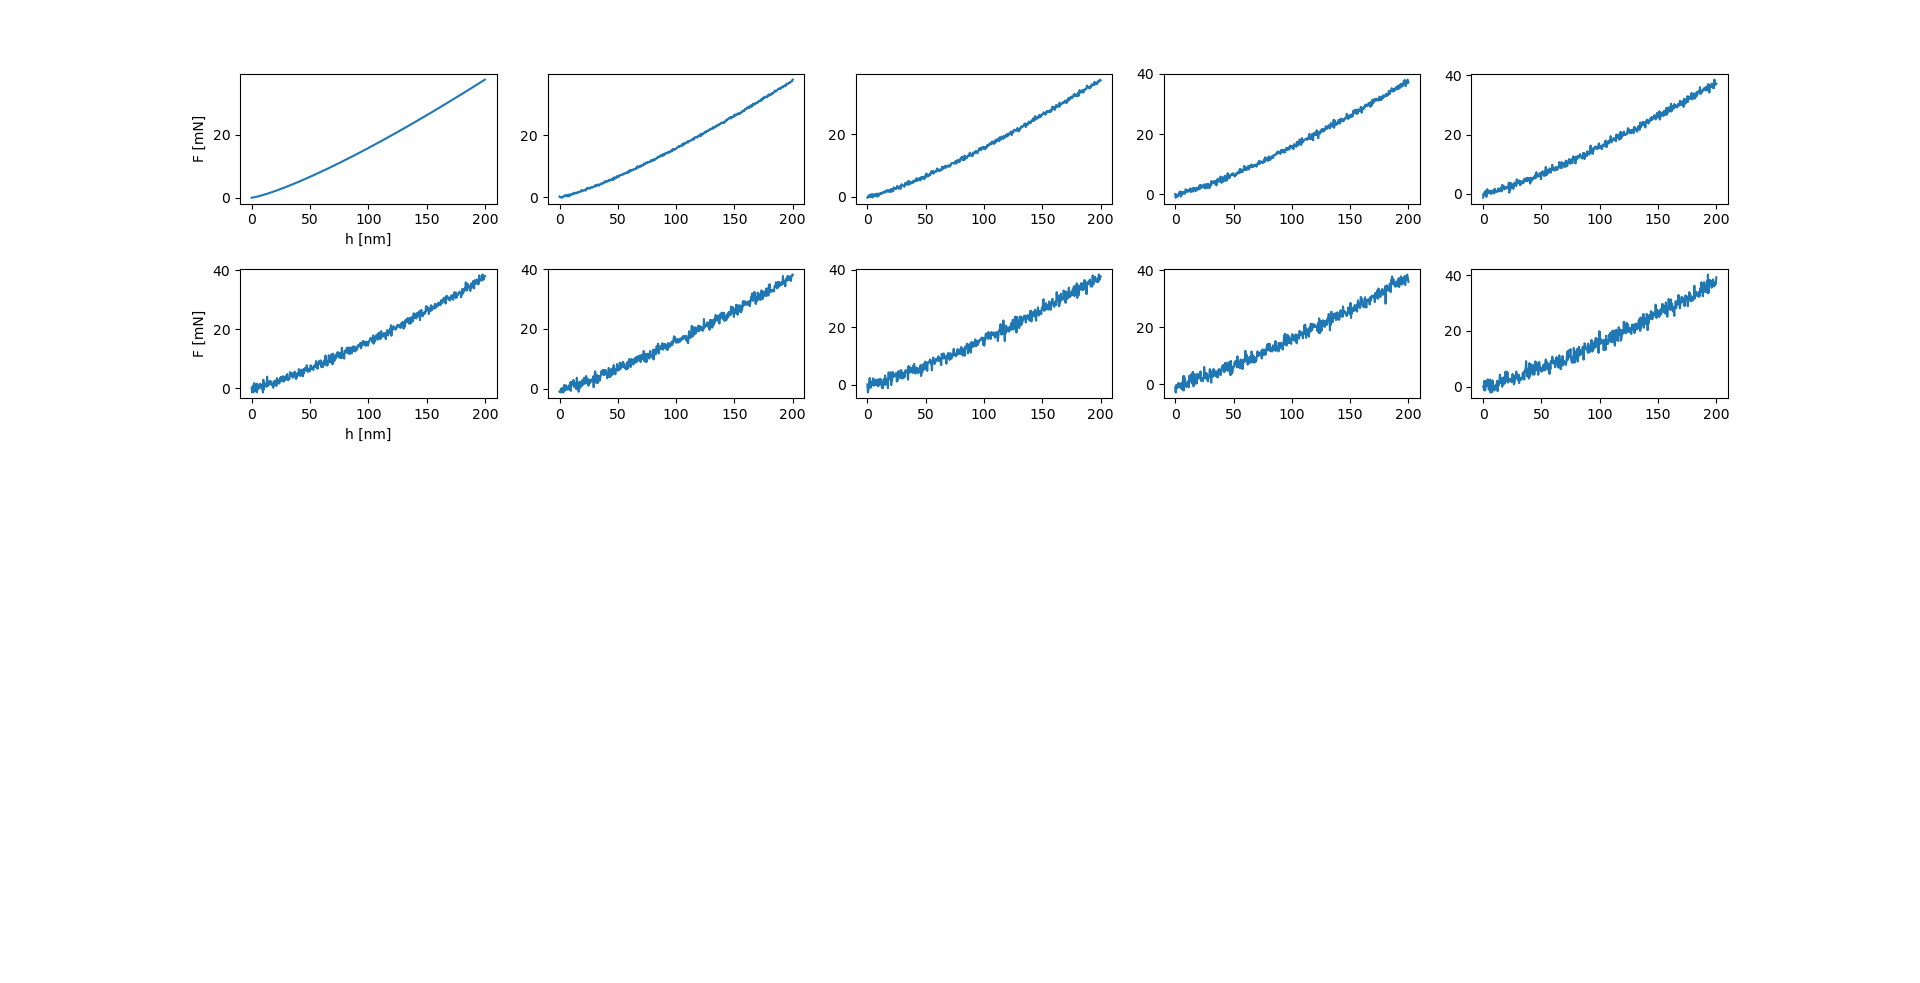

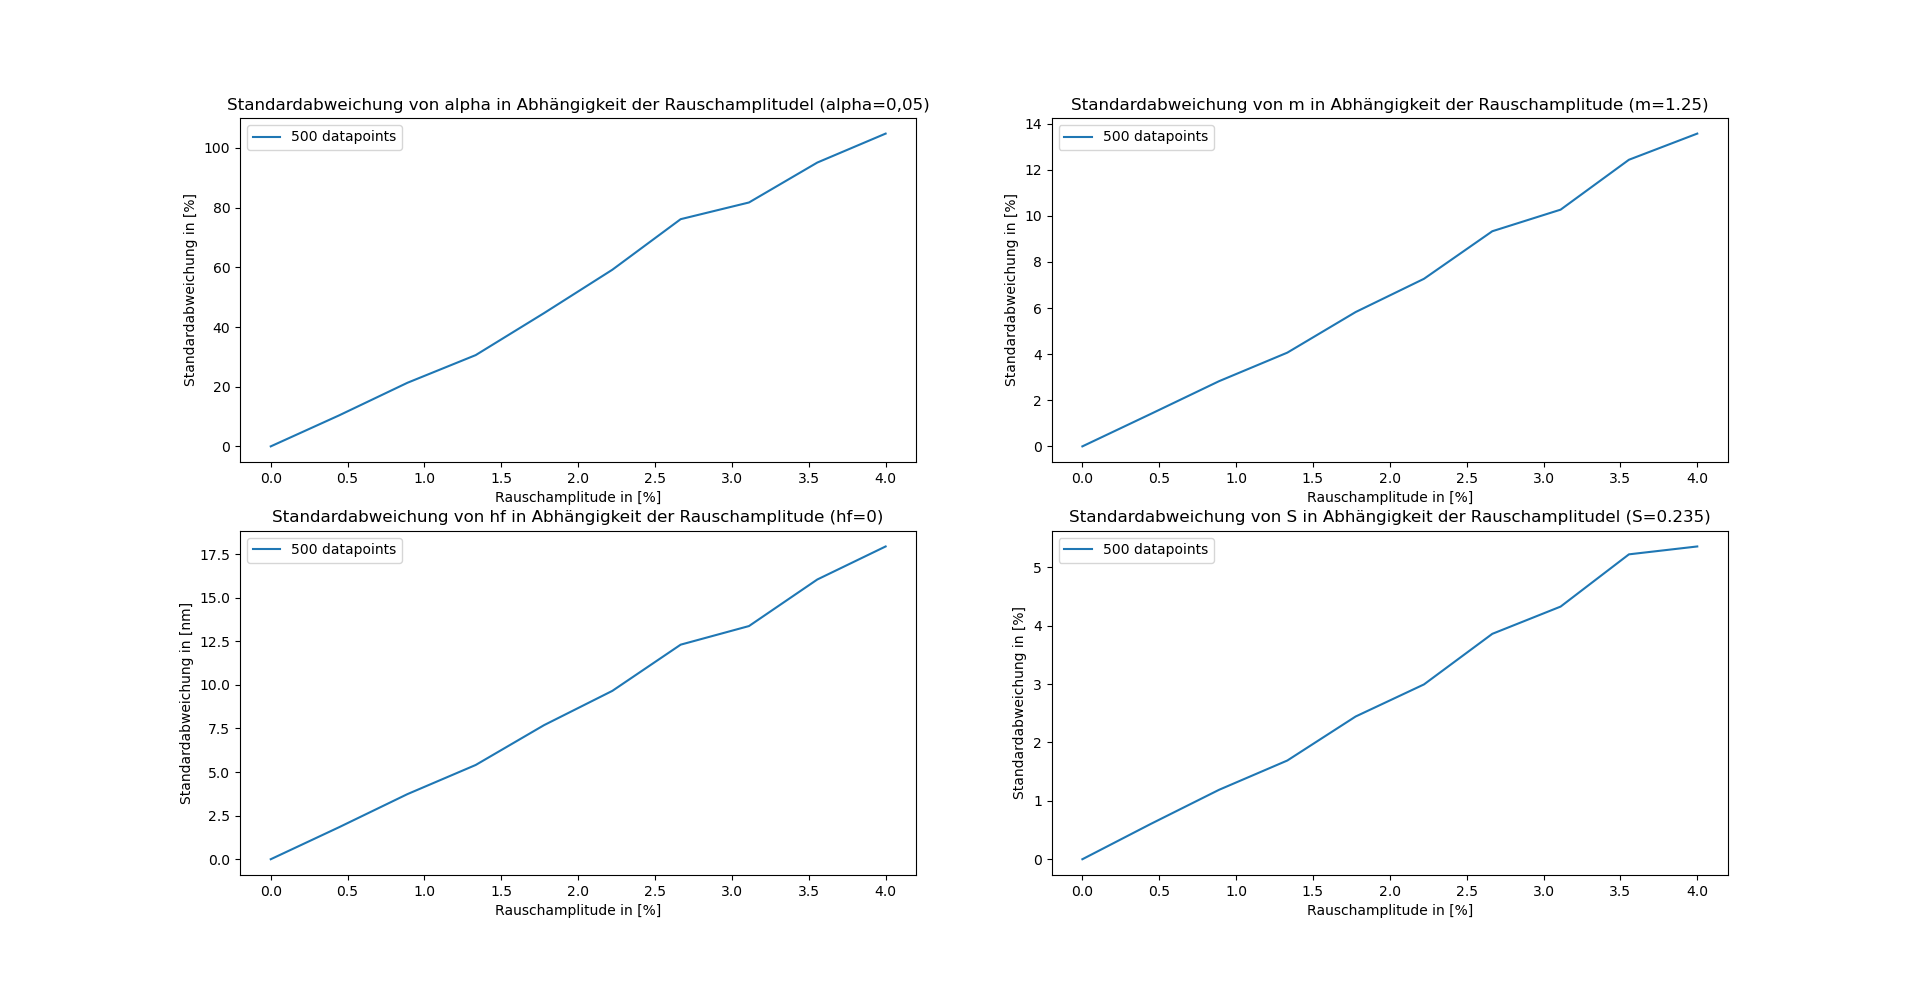

Es ist zu sehen, dass die Standardabweichung annähernd linear mit der Rauschamplitude ansteigt. Weiterhin nimmt die Güte deutlich zu mit steigender Anzahl an Datenpunkten. $\alpha$ hat dabei deutlich größere Abweichungen als $m$

## Überprüfung der Ausrichtung
### Ebenenfitting


Ebenengleichung: $ ax+by+c = z$

Gradient: $\begin{vmatrix} \frac{\partial z}{\partial x} \\
            \frac{\partial z}{\partial y} \end{vmatrix}= (\frac{a}{b}) $


Ebenensteigung: $\arctan({\sqrt{a^2+b^2}})$             [°]

### Mit simulierten Daten

solution: 0.296112 x + 0.612135 y + 4.993388 = z


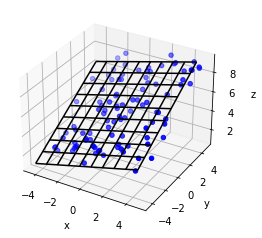

Ebenensteigung: 0.6799938662111179


In [4]:
# These constants are to create random data for the sake of this example
N_POINTS = 100
TARGET_X_SLOPE = 0.3
TARGET_y_SLOPE = 0.6
TARGET_OFFSET  = 5
EXTENTS = 5
NOISE = 0.5



# Create random data.
# In your solution, you would provide your own xs, ys, and zs data.
xs = [np.random.uniform(2*EXTENTS)-EXTENTS for i in range(N_POINTS)]
ys = [np.random.uniform(2*EXTENTS)-EXTENTS for i in range(N_POINTS)]
zs = []
for i in range(N_POINTS):
    zs.append(xs[i]*TARGET_X_SLOPE + \
              ys[i]*TARGET_y_SLOPE + \
              TARGET_OFFSET + np.random.normal(scale=NOISE))
    
# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)

# Manual solution
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

# Or use Scipy
# from scipy.linalg import lstsq
# fit, residual, rnk, s = lstsq(A, b)

print("solution: %f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
#print("errors: \n", errors)
#print("residual:", residual)

# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax.plot_wireframe(X,Y,Z, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#print(Z)

#compute slope of plane (gradient)
Z_grad = fit[0:2]
max_grad = np.linalg.norm(Z_grad)
print('Ebenensteigung:', max_grad)
hide_toggle()

### Mit realen Daten aus Array Antastung

Es werden 2 Array Anstastungen, mit jeweils 3x3 Datenpunkten und einem Rasterabstand von 10um aufgenommen. Die erste Messung startet im Ursprung (0,0) und die zweite bei (30,30).
Durch die Datenpunkte wird eine Ebene gefittet und die maximale Steigung bestimmt.


solution: -0.006411 x + -0.001016 y + 3.815257 = z
solution 2: -0.006278 x + -0.000982 y + 3.909630 = z


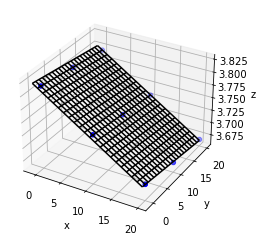

Ebenensteigung in [%]: 0.6490895412999664
Ebenensteigung in [°]: 0.37189568961562536

Ebenensteigung 2 in [%]: 0.6354707654129035
Ebenensteigung 2 in [°]: 0.36409302770142143


In [5]:
#data from modulus mapping (23.06.22)
xs = [0, 0, 0, 10, 10, 10, 20, 20, 20] #[um]
ys = [0, 10, 20, 20, 10, 0, 0, 10, 20]   #[um]
zs = [3.815748, 3.805186, 3.794780, 3.730393, 3.740052, 3.751712, 3.687332, 3.675042, 3.668683]   #[um]

#data from modulus mapping (24.06.22) start position at (30,30)
#test if second dataset produces same plane gradient
xs_2 = [30, 30, 30, 40, 40, 40, 50, 50, 50] #[um]
ys_2 = [30, 40, 50, 50, 40, 30, 30, 40, 50]   #[um]
zs_2 = [3.691764, 3.681322, 3.672858, 3.610436, 3.618069, 3.629398, 3.566891, 3.556478, 3.545868 ]   #[um]

# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b')

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)


# do fit on second dataset
tmp_A_2 = []
tmp_b_2 = []
for i in range(len(xs_2)):
    tmp_A_2.append([xs_2[i], ys_2[i], 1])
    tmp_b_2.append(zs_2[i])
b_2 = np.matrix(tmp_b_2).T
A_2 = np.matrix(tmp_A_2)

# Manual solution
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

# Manual solution
fit_2 = (A_2.T * A_2).I * A_2.T * b_2
errors_2 = b_2 - A_2 * fit_2
residual_2 = np.linalg.norm(errors_2)

# Or use Scipy
#from scipy.linalg import lstsq
#fit, residual, rnk, s = lstsq(A, b)

print("solution: %f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
#print("errors: \n", errors)
#print("residual:", residual)
print("solution 2: %f x + %f y + %f = z" % (fit_2[0], fit_2[1], fit_2[2]))

# plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1]),
                  np.arange(ylim[0], ylim[1]))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax.plot_wireframe(X,Y,Z, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#print(Z)

#compute slope of plane (gradient)
Z_grad = fit[0:2]
max_grad = np.linalg.norm(Z_grad)
max_deg = np.rad2deg(np.arctan(max_grad))
print('Ebenensteigung in [%]:', max_grad*100)
print('Ebenensteigung in [°]:', max_deg)

Z_grad_2 = fit_2[0:2]
max_grad_2 = np.linalg.norm(Z_grad_2)
max_deg_2 = np.rad2deg(np.arctan(max_grad_2))
print('\nEbenensteigung 2 in [%]:', max_grad_2*100)
print('Ebenensteigung 2 in [°]:', max_deg_2)
hide_toggle()

Man kann erkennen, dass beide Ebenen nahezu den gleichen Gradienten und die gleiche Steigung aufweisen. Der Offsetparameter weist eine größere Abweichung auf, was durch thermischen Drift zu erklären ist, da die Messungen an verschiedenen Tagen durchgeführt wurden. Demnach lässt sich sagen, dass MEMS und Probe eine Winkelabweichung von ~0,37° aufweisen. 
Weiterhin wurde eine 5x5 Array-Antastung auf einer strukturierten SI-Probe durchgeführt (Ätztiefe ca 0.5um). Die Messung liefert ähnliche Ergebnisse (die 2 verschiedenen Oberflächentiefen sind klar erkennbar; deren Ebenensteigung weist ähnliche Werte auf 0.448 und 0.477°; die Steigung weist zwar eine kleine Abweichung zu der Referenzmessung auf der Saphir-Probe auf, allerdings wurde die Messung bei großen thermischen Drift durchgeführt) 

## Annäherung der Tastspitze an Sapphir Probe

-snap-in Effekt ist erkennbar (mit altem MEMS)

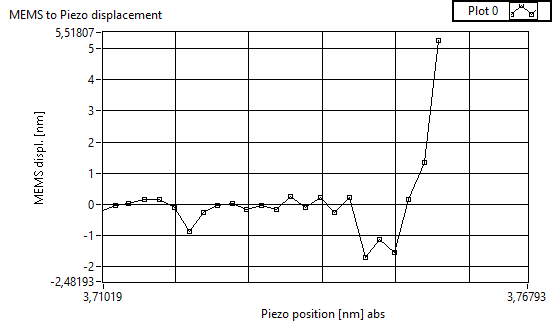

## Dynamik des Piezotisches
Um die dynamischen Eigenschaften des Piezotisches zu untersuchen, wurde die Sprungantwort für verschiedene Sprunghöhen aufgenommen. Aus dem Antwortverhalten kann die Zeitkonstante des Tisches abgeleitet werden, um eine sinnvolle sampling rate für die Messung bestimmen zu können. Die Zeitkonstante wurde bestimmt, indem die Datensätze an die DGL eines Systems 1. Ordnung gefittet wurden. Die Zeitkonstante stellt der Parameter t1 dar.

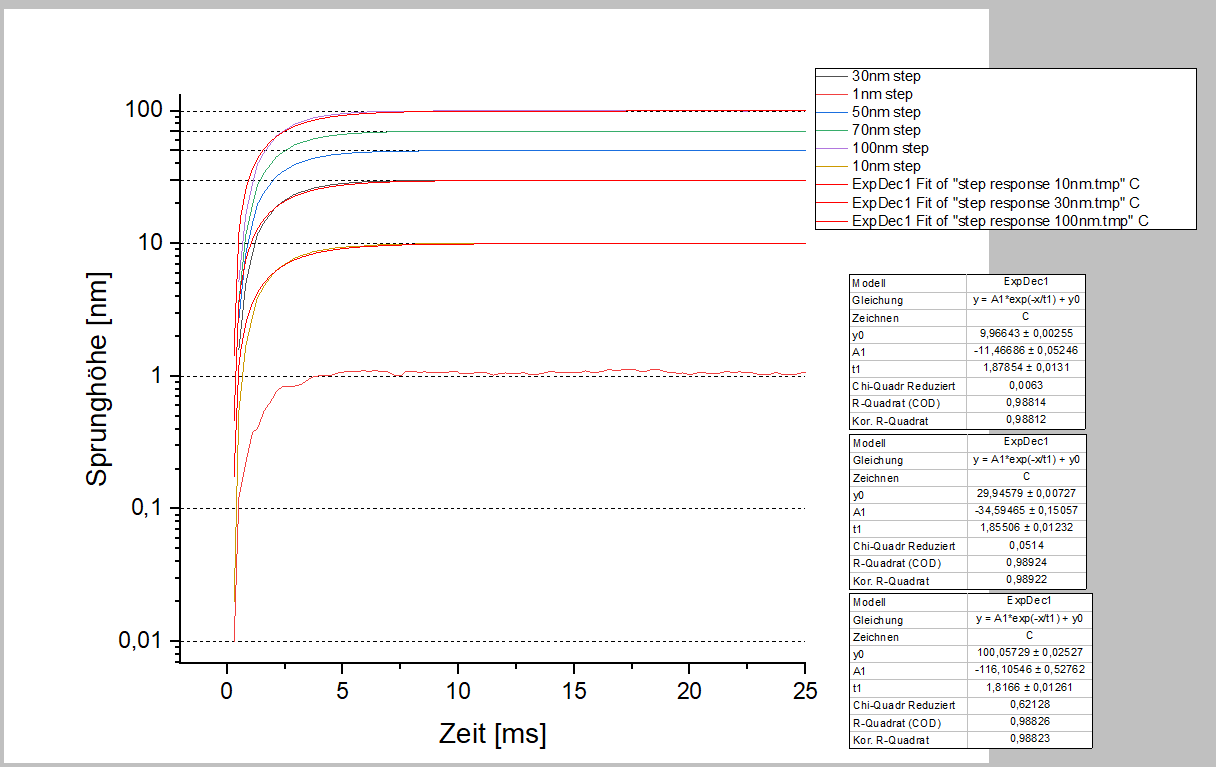

Die Zeitkonstante $\tau$ ist weitestgehend unabhängig von der Sprunghöhe und hat einen Wert von circa 1.8ms. Üblicherweise wird eine Warteperiode von 3 $\tau$ verwendet, was 5.4ms entspricht. Somit kann die maximal mögliche Sampling rate von 90Hz (11ms) genutzt werden.

## Kalibrierung des Kapazität-Verschiebung Koeffizienten
Um S zu bestimmen, fährt der Piezotisch in diesem Fall eine Rampe von 1um, wobei die Kapazität und die Position des Piezotisches in einer Textdatei gespeichert werden. Es wird eine Sapphir Probe genutzt, da durch die sehr hohe Steifigkeit der Probe keine Indentation in das Material erfolgt. Es wird der Koeffizient gesucht, sodass $\delta{z}*S=\delta{C}$. Über ein Linienfitting wird S ermittelt. Die Messung liefert:

$\delta{C}=0.43409pf$ und
$\delta{z}=1000nm$.
Somit folgt: $S=434.148 \frac{aF}{nm}$ (bei vorläufigen MEMS)

Zusätzlich wurde die Untersuchung für verschiedene Laderaten wiederholt. Die Abweichungen betragen weniger als 0.5%.

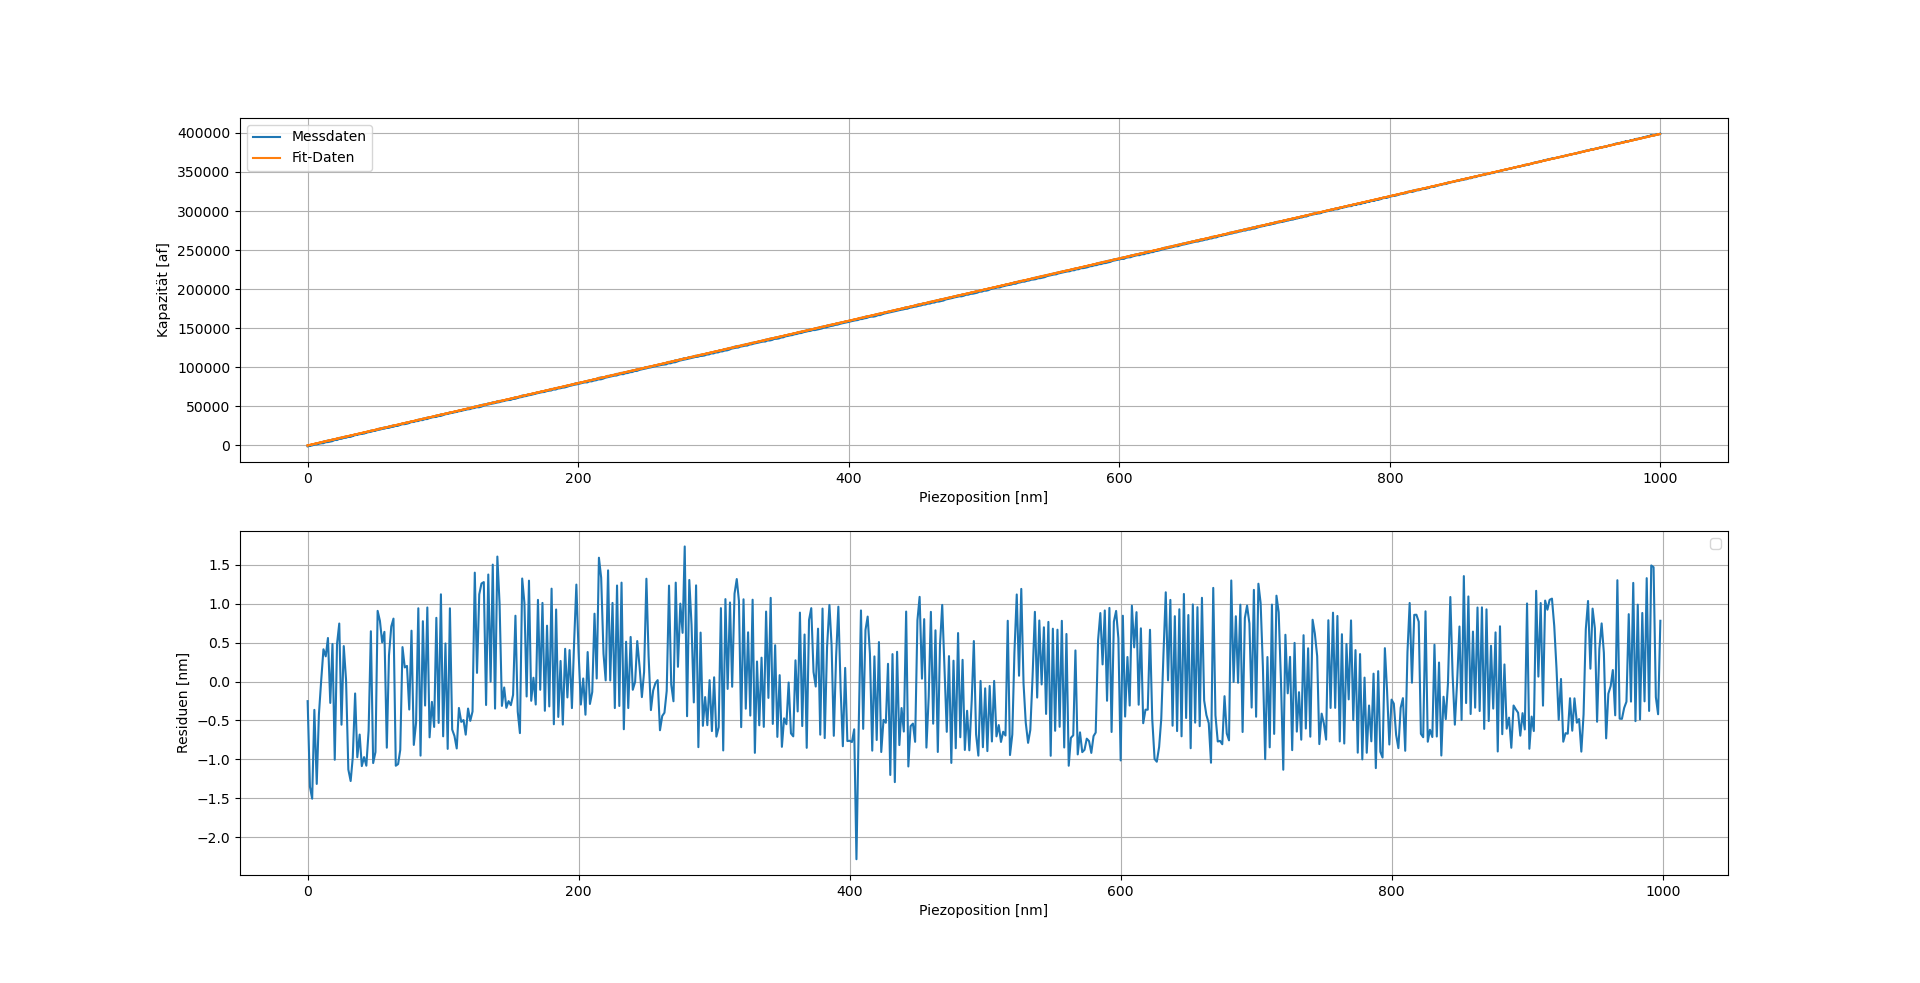

Weiterhin wurde eine Arraymessung durchgeführt (2x2), um die Sensitivität des resultierenden Koeffizienten zu untersuchen.

## Driftuntersuchung
Um den Drift des Messaufbaus zu untersuchen, wurde die Tastspitze in eine Sapphier Probe gedrückt, mit einer MEMS-Verschiebung von circa 500nm. Dabei wurde das MEMS Signal ausgelesen und gespeichert über einen Zeitraum von >10h. Der durchnschnittliche Drift beträgt circa -0.1 nm/min

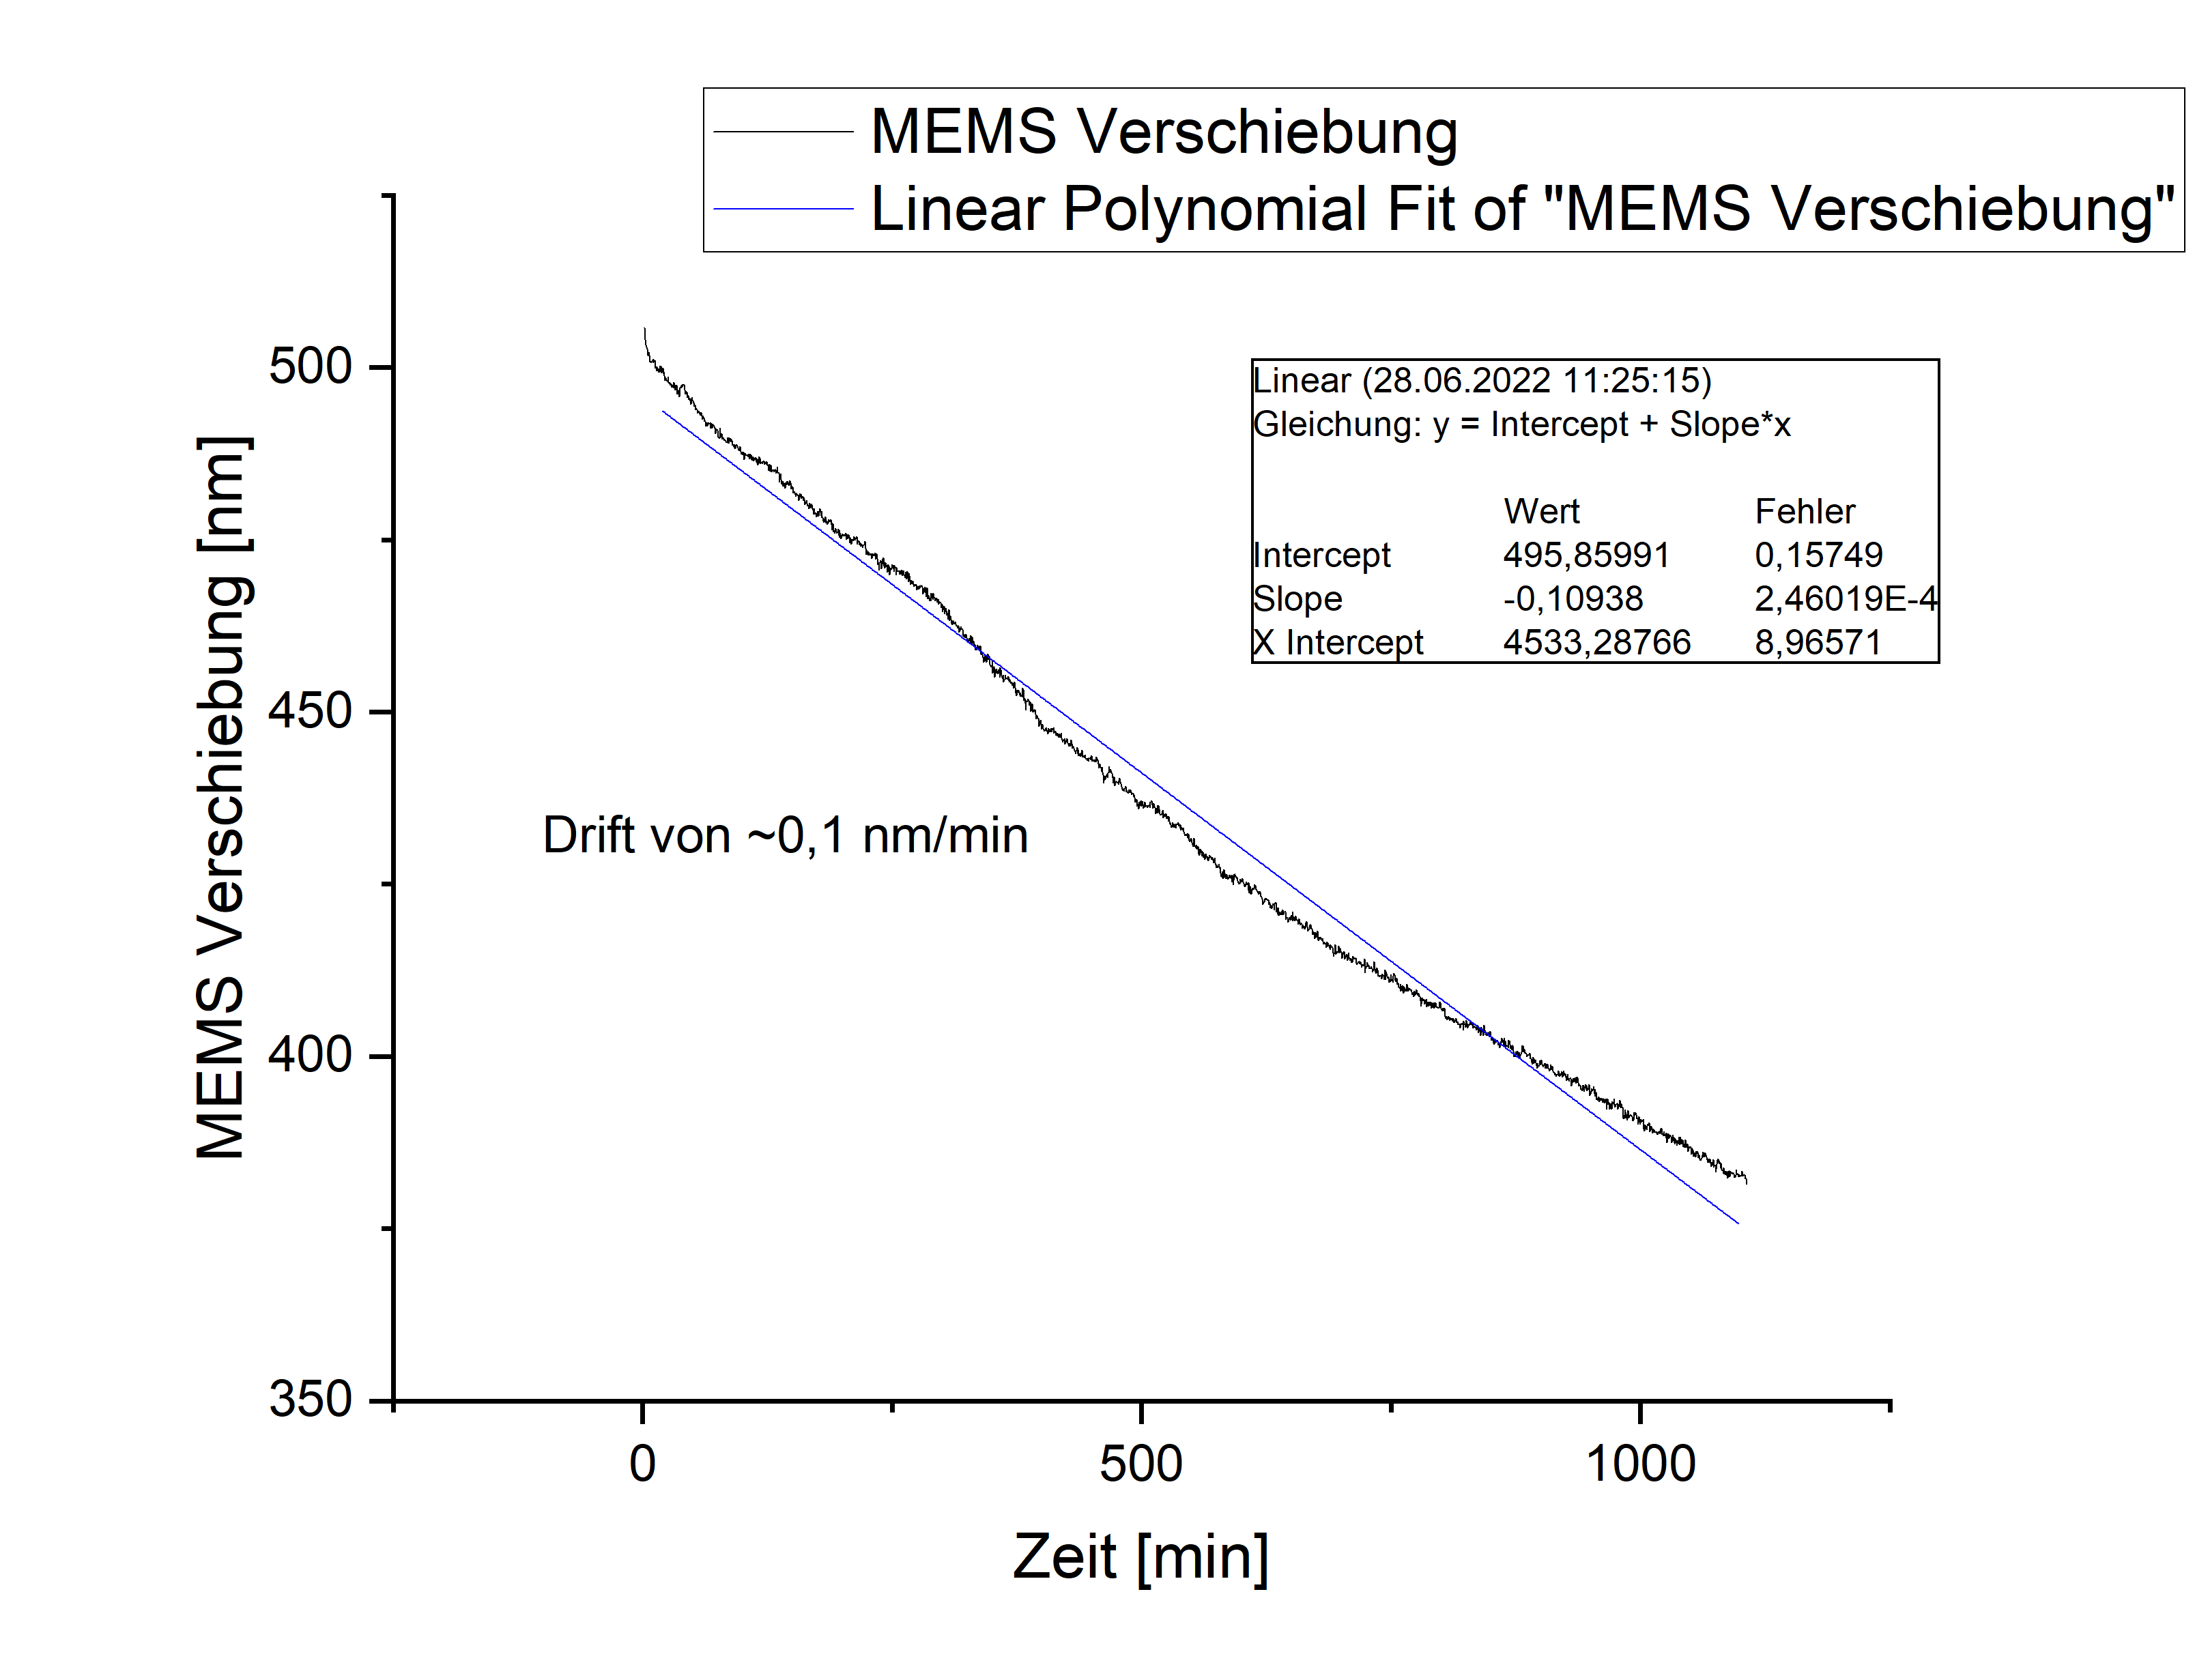

## Drift Test ohne Kontakt

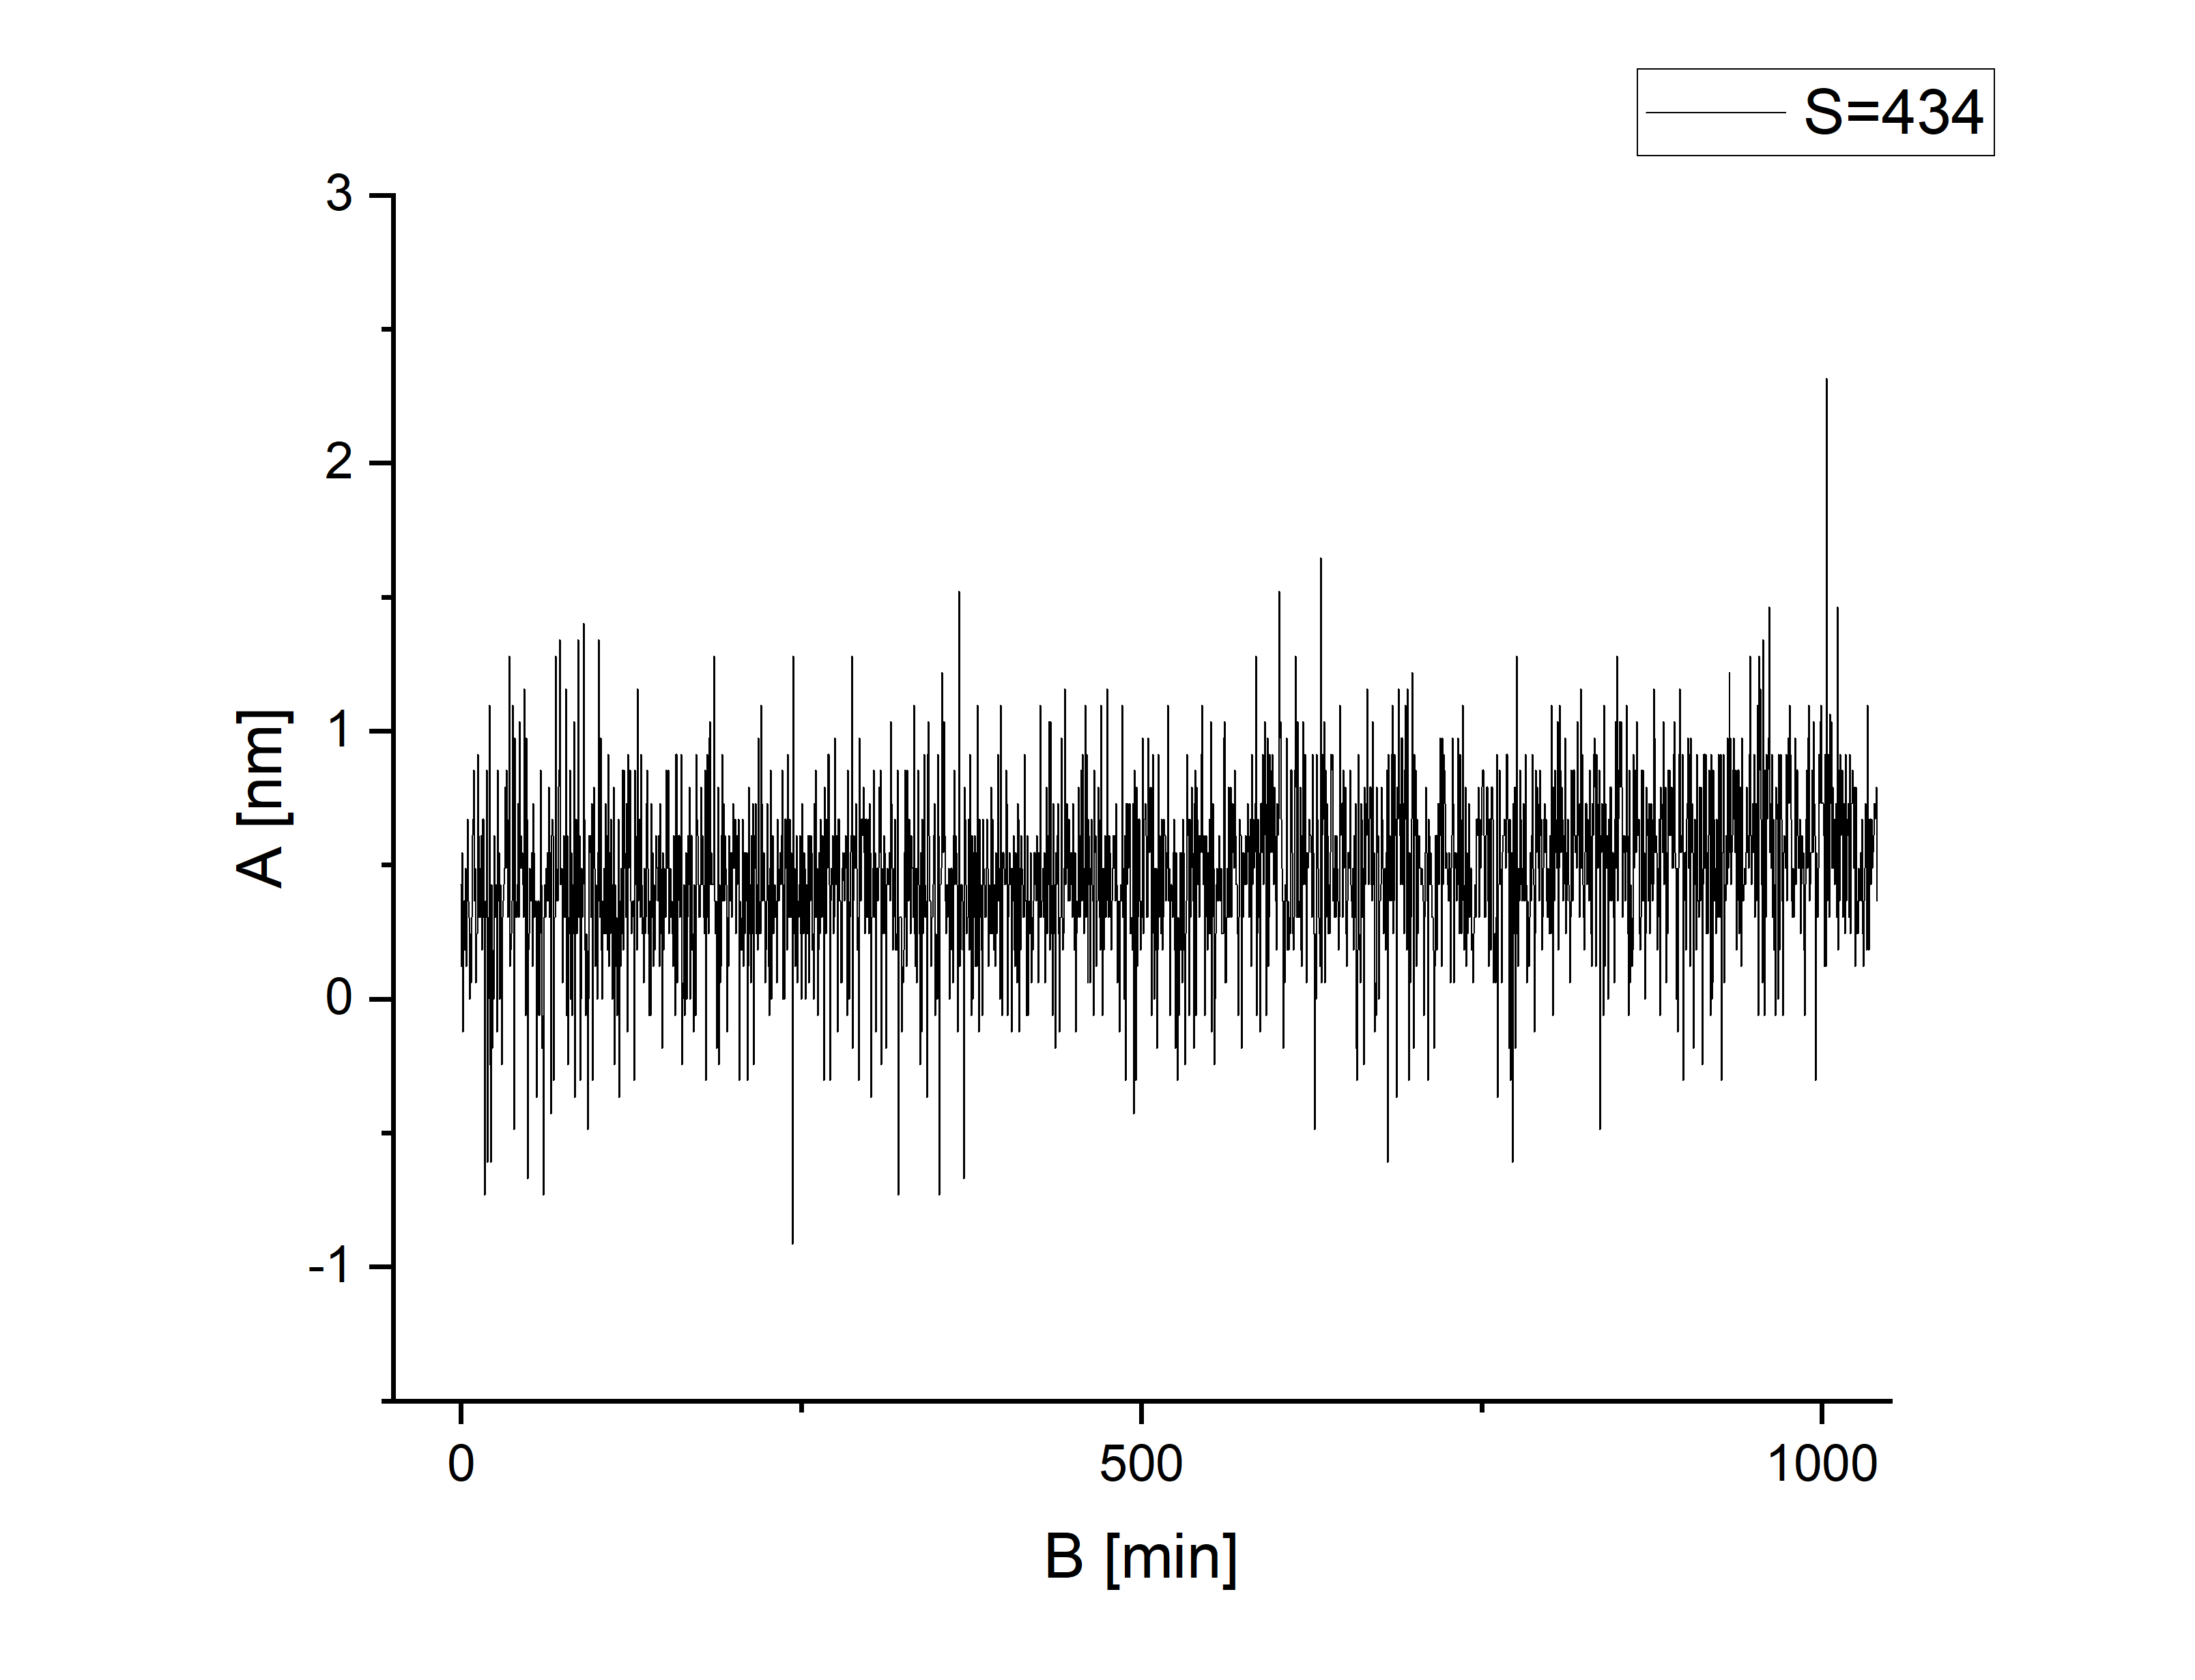

## Testen der möglichen Sampling Rate des Labview Programms

Es werden verschieden Load-functions erzeugt, mit einer sampling rate von 50,40,30,20 ms. Der geschrieben Datensatz wird verglichen mit den Eingangsdaten. Die maximal erreichbare sampling rate beträgt derzeitig 20s/s (50ms).

Durch Änderung der Piezostage Ansteuerung kann sampling rate von 40s/s (25ms Auflösung) erzielt werden.

## Testmessung: Partial-unload

Durchgeführt wurde eine partial-unload Messung, mit 5 Zyklen und 25% Entlastung (unten dargestellt). Die Messung wurde mit einer  Datenrate von 20 samples/s durchgeführt. 
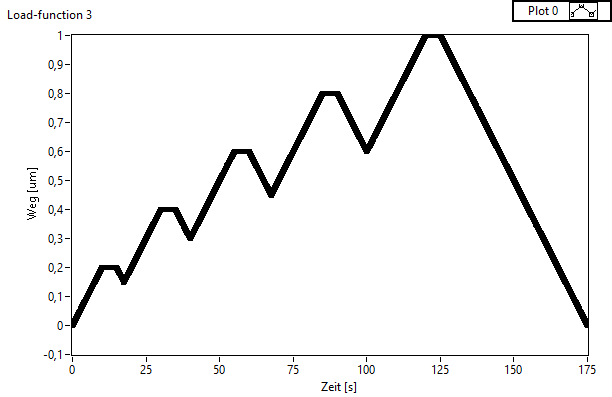

Die Messdaten werden verarbeitet und die fit Parameter, sowie die relative Kontaksteifigkeit $S$ wird ausgewertet. Im Idealfall sind die Parameter $\alpha, m, h_f \space und \space S$ für jeden Zyklus gleich, wobei $\alpha=1, m=1, h_f=100 \space und \space S=1 $ gelten sollte. (Messung mit defektem MEMS, daher S ungleich 1)

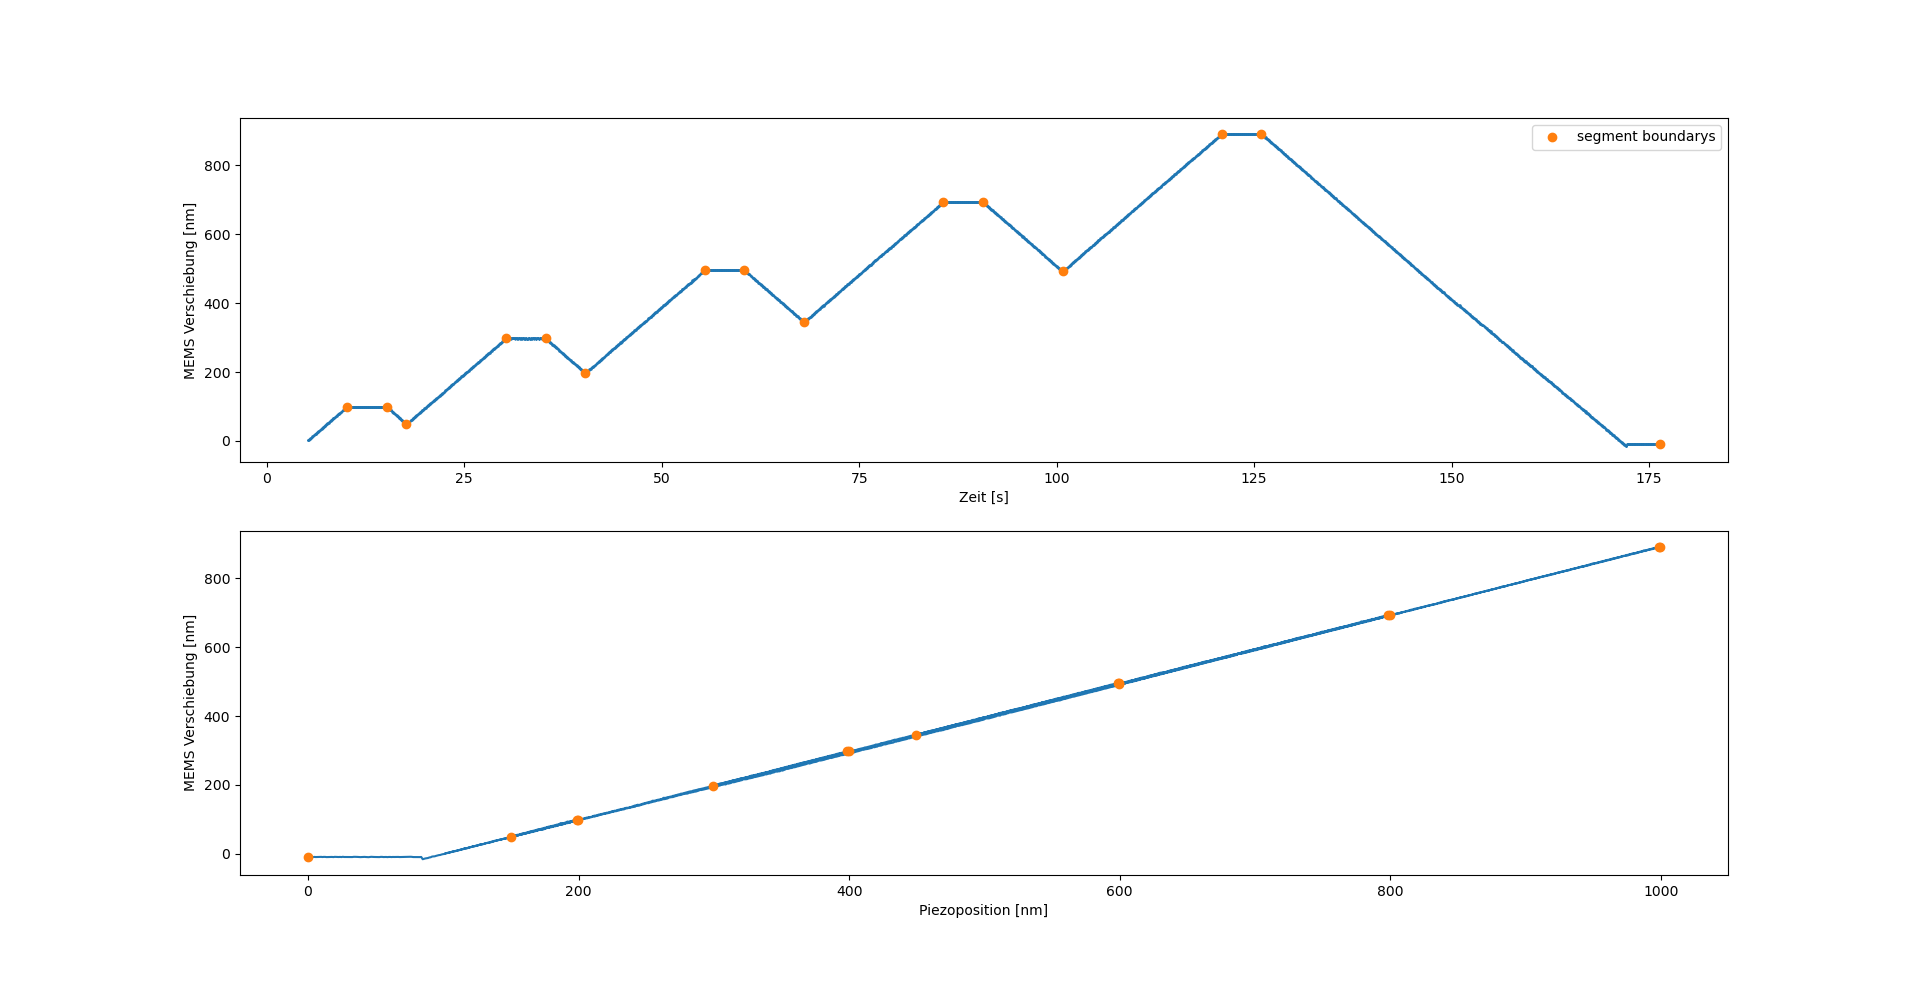

In [6]:
print('Fit Parameter:\n')
for n,i in enumerate(popt_log):
    print('Zyklus %i : alpha=%f ,m = %f , hf = %f, S = %f '%(n+1,i[0],i[1], i[2], S[n]))

Fit Parameter:

Zyklus 1 : alpha=0.460914 ,m = 1.079252 , hf = 234.793691, S = 0.744916 
Zyklus 2 : alpha=0.470503 ,m = 1.058782 , hf = 261.515177, S = 0.720807 
Zyklus 3 : alpha=0.642509 ,m = 1.013433 , hf = 285.295074, S = 0.713575 
Zyklus 4 : alpha=0.020189 ,m = 1.436006 , hf = -160.352448, S = 0.753592 
Zyklus 5 : alpha=0.556297 ,m = 1.032722 , hf = 287.255601, S = 0.732970 


## Messung mit fibed MEMS auf Saphir Probe

Es wurde zunächst erneut eine Testmessung auf der Saphir-Probe durchgeführt, um das Messsystem zu analysieren. 
LF: 50-10-50, 0,5um, 0,4um offset.

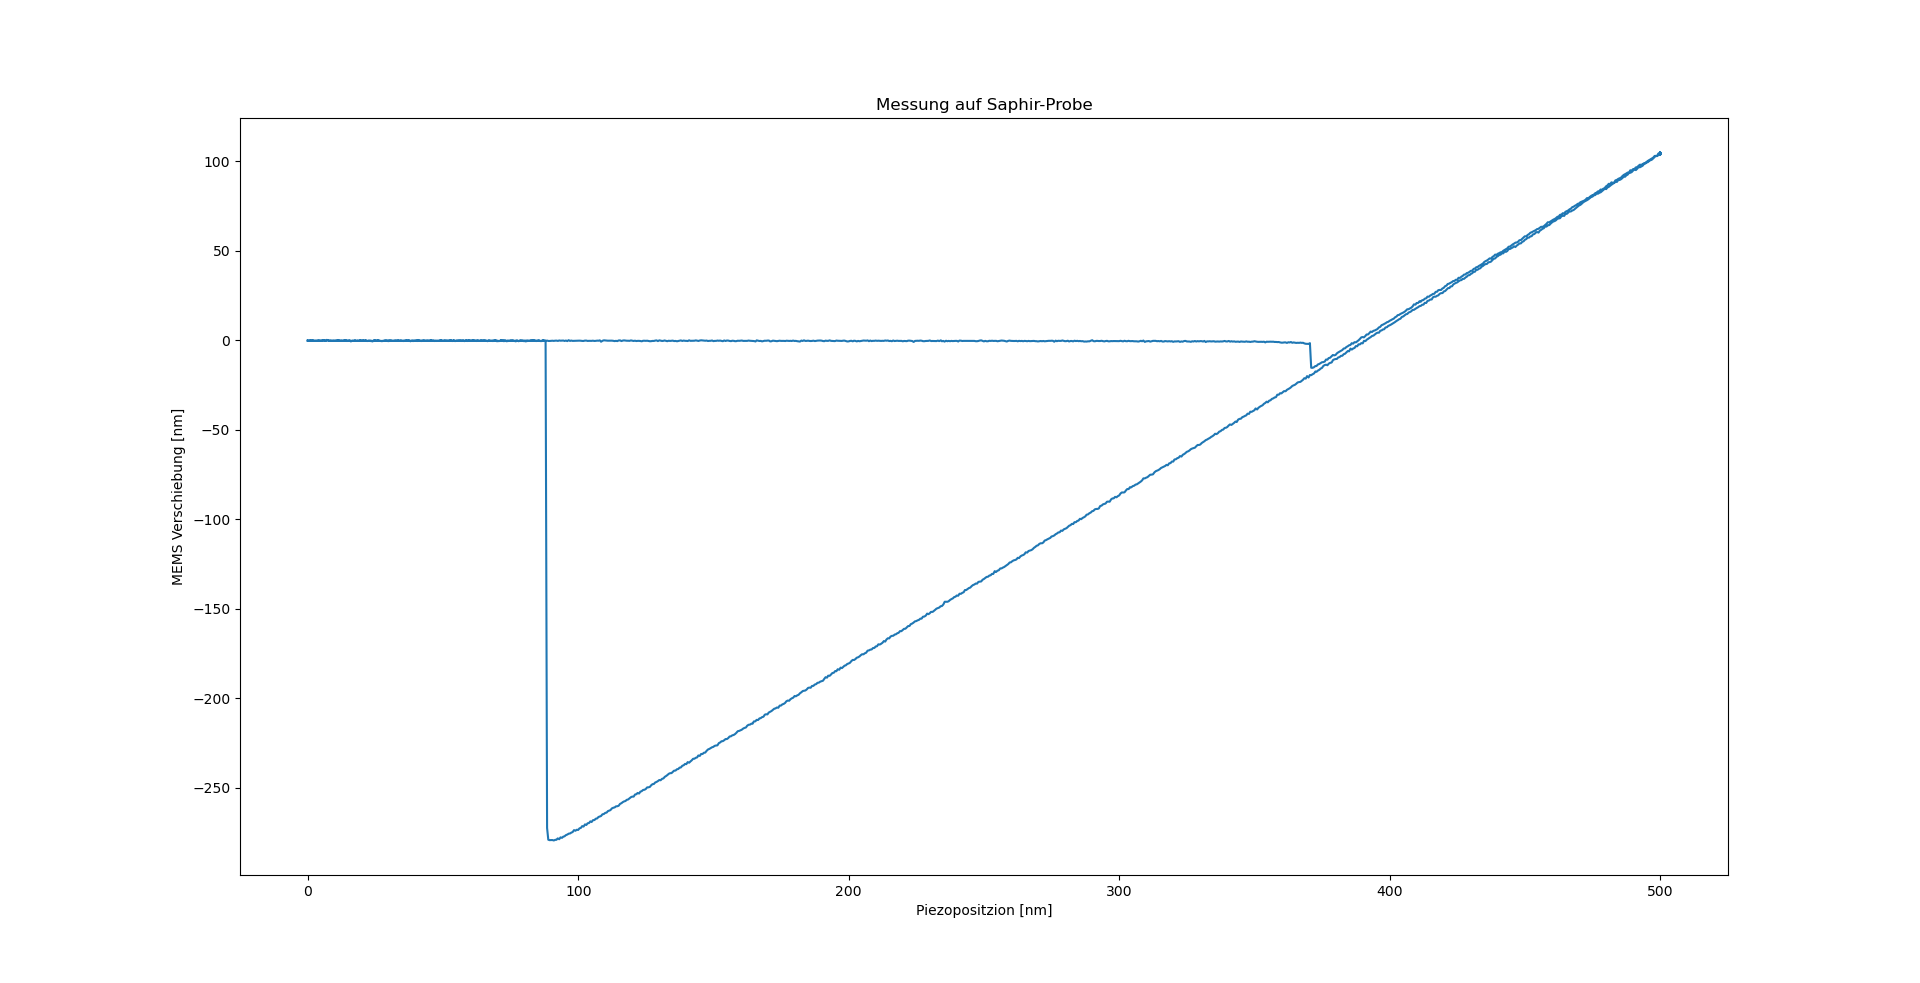

Es zeigt sich das erwartete Verhalten, mit einem deutlich sichtbaren snap-in und einer hohen pull-off Force.

## MEMS Auflösung
Es wurde ein Stufentest durchgeführt, mit einer Stufenhöhe von 500pm, 10Hz, bei einer Datenrate von 50 samples/sekunde (MEMS step test,0,5nm,10Hz-1).

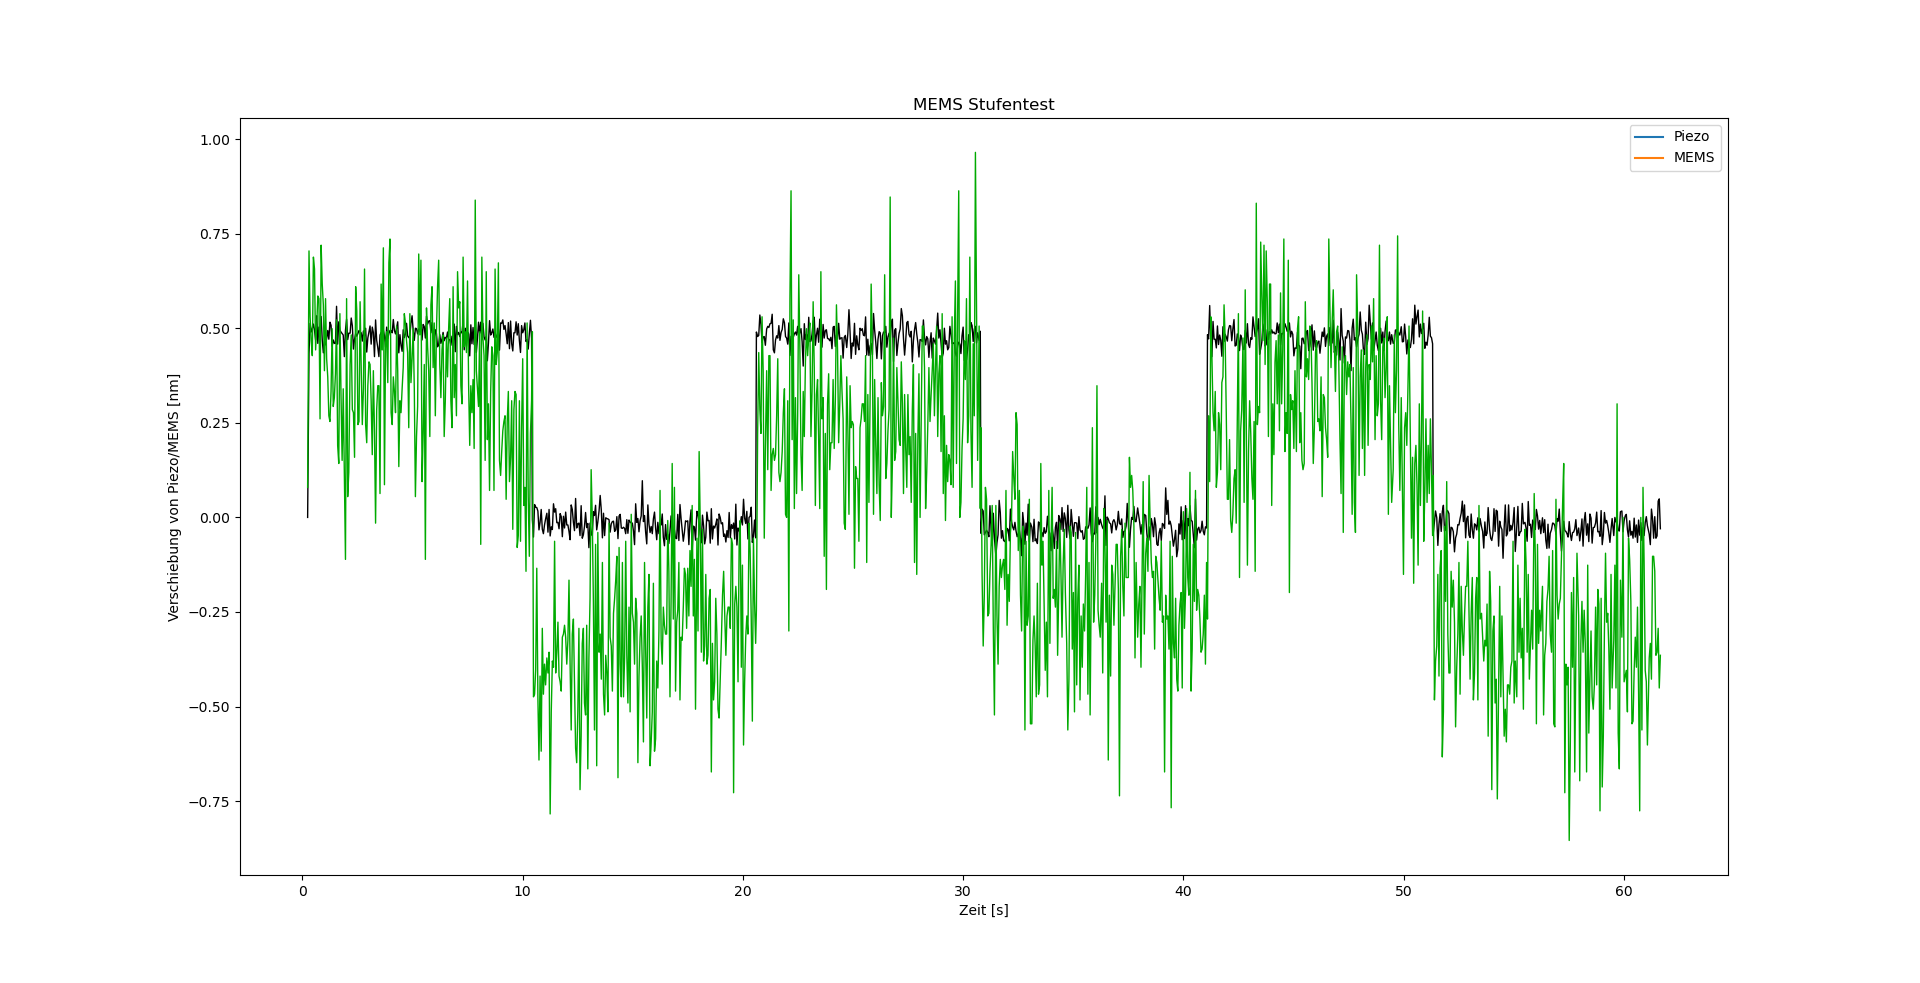

Die Sprunghöhe von 500 pm kann deutlich von dem MEMS detektiert werden. Darüberhinaus beträgt die Auflösung des MEMS außer Kontakt 50 af und in Kontakt, nach Erreichen des thermischen Gleichgewichts 70-80 af(letzte Aussage noch nicht richtig untersucht).

# MEMS Dynamik


Zur Untersuchung der dynamischen Eigenschaften des MEMS, wurden zunächst die Sprungantworten aufgezeichnet, für 1, 5, 10, 20. 50, 100 nm. Da zuvor während der Messung ein relativ starker Drift auftrat, war die Vermutung, dass dies an den dynamischen Eigenschaften des MEMS liegen könnte. Bei den Sprungantworten, war jedoch erst ab einer Sprunghöhe von 20(50)nm ein Überschwingen gefolgt von asymptotischen Abfall erkennbar. 
Im nächsten Schritt wurde das Anwortverhalten des MEMS auf eine lineare Rampe bestimmt, wobei die Schrittweite (0,2 0,5 1 2 5 nm) und das zeitliche Intervall(50,100 ms) verändert wurde (Bewegung des Piezos von insgesamt 0,4um). Hierbei zeigte sich, das zunächst ein Überschwingen auftrat, gefolgt von asymptotischen Abfall. Je größer die Schrittweite und je kleiner das zeitliche Intervall, desto größer das Überschwingen. Der minimale Abfall (ca 1nm) trat bei 100ms und Schrittweiten von <=1nm auf. Ein Vergrößerung des zeitlichen Intervalls brachte keine Vorteile. 

Unten in der Abbildung ist hierbei der Verlauf des MEMS Signals (10s) nach dem Sprung dargestellt. Die Y-Ache wurde hier normalisiert zur besseren Darstellung, indem die Position des Piezos als Referenz von der MEMS Verschiebung subtrahiert wurde. Bei Sprunghöhen von 100 und 50 (20) ist ein Überschwingen deutlich erkennbar. Bei kleineren Sprunghöhen ist kein Überschwingen erkennbar, was jedoch vermutlich an dem Auflösungsvermögen des MEMS liegt.

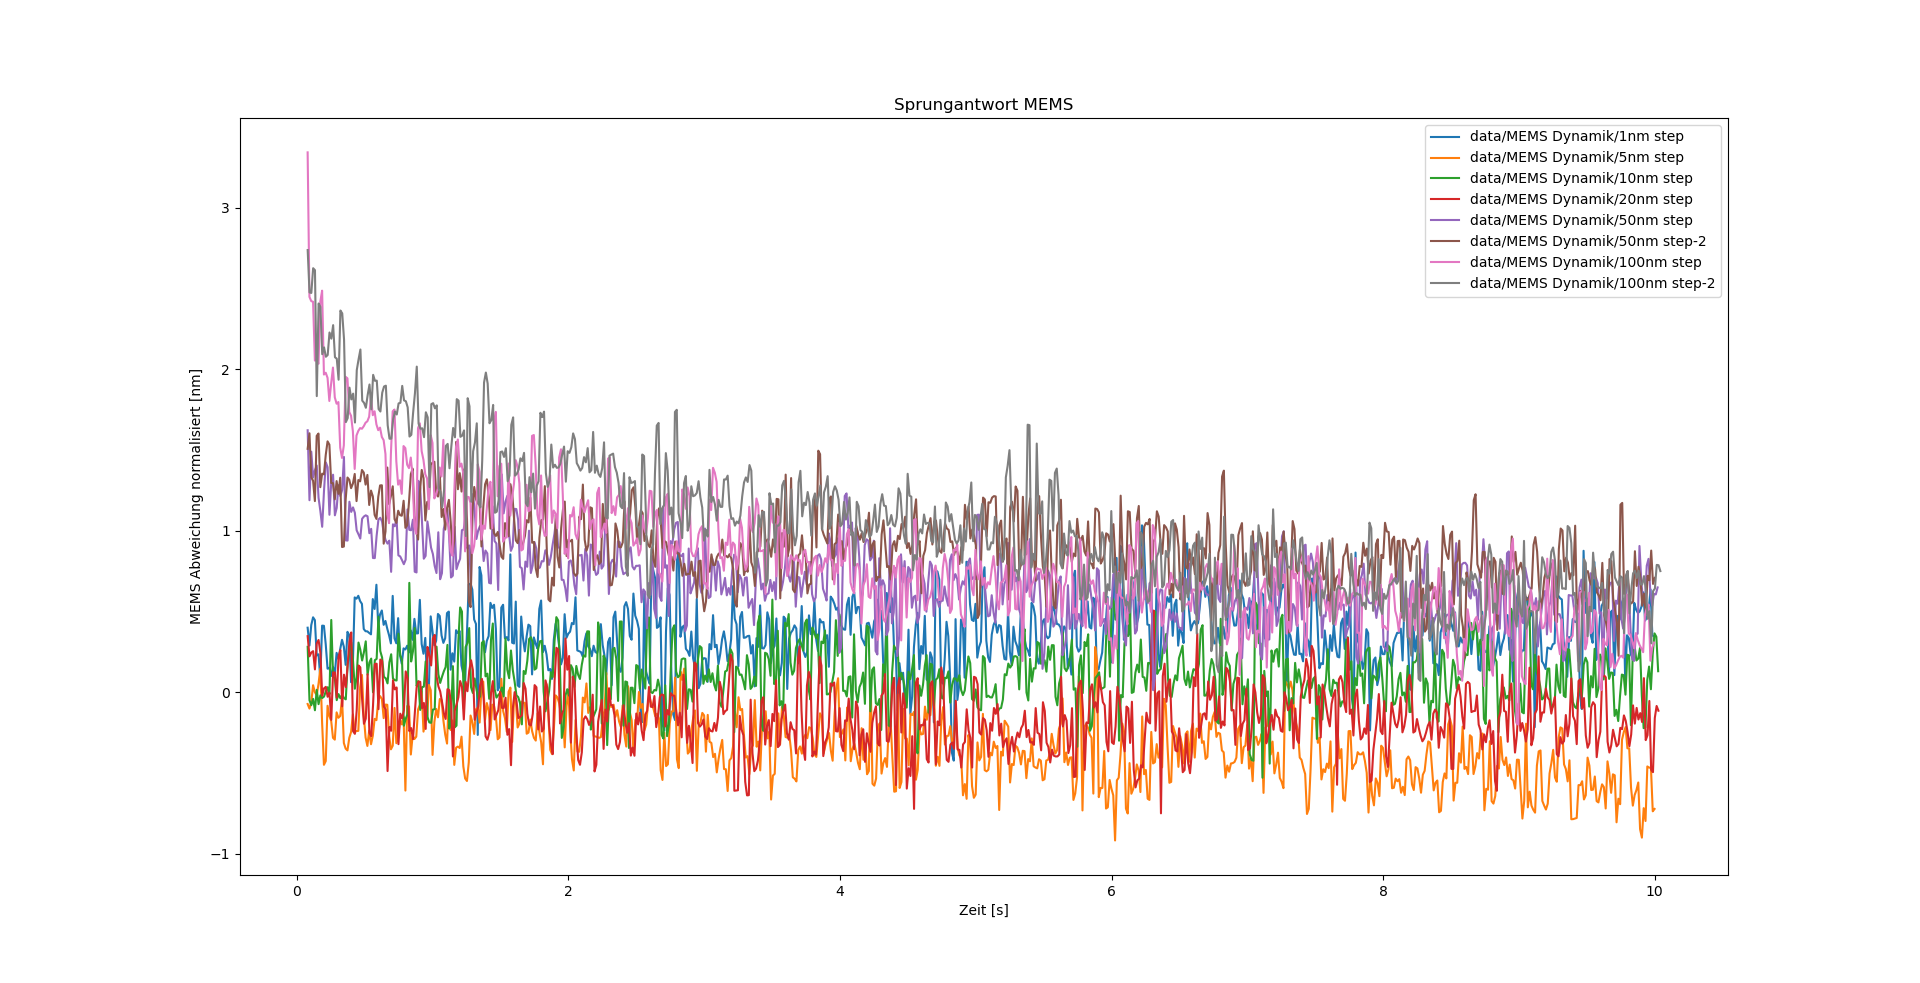